 # Predict hotel booking cancellations
---
### Objectives: 
* Perform data exploration, cleaning, imputation.
* Use data visualisation techniques to explore the data set.
* Come up with a binary classification model to predict whether a booking will be cancelled or not
* For cancelled bookings, come up with a regression model to predict how many days in advance the guest cancels.
* Then create a decision support tool by combining the two above models.

Project Members:
- Ambika Kumari Goyal, 442033
- Ankit Parab, 442240
- Nallaperumal Krishnan, 441056
- Siddhi Chavan, 442931
- Spurthi Kunduri, 443194

## Table of Contents

- [1. Loading Data](#1.-Loading-Data)
- [2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis:)
- [3. Data Cleaning and Preprocessing](#3.-Data-Cleaning-and-Preprocessing)
- [4. Model 1 - Binary Classification](#4.-Model-1---Binary-Classification)
     - [4.1 Logistic Regression Model](#4.1-Logistic-Regression-Model---'Predicting-if-the-booking-will-be-canceled-or-not')
     - [4.1.1 Fitting the model](#4.1.1-Fitting-the-model)
     - [4.1.2 Hyperparametric Tuning](#4.1.2-Hyperparametric-Tuning)
- [5. Model 2 : Regression](#5.-Model-2-:--Regression)
     - [5.1 Data Preparation](#5.1-Data-Preparation)
     - [5.2 Model Selection and fitting the model](#5.2-Model-Selection-and-fitting-the-model)
          - [5.2.1 Backward Feature Selection](#5.2.1-Backward-Feature-Selection)
          - [5.2.2 Fitting the model using the features](#5.2.2-Fitting-the-model-using-the-features)
          - [5.2.3 Hyperparametric Tuning](#5.2.3-Hyperparametric-Tuning)
- [6. Prediction Tool - combining both the models](#6.-Prediction-Tool---combining-both-the-models)
- [7. Summary and Conclusion](#7.-Summary-and-Conclusion)

#### Importing all required libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import sort_dataframeby_monthorweek as sd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import math
import pandas.tseries  
plt.style.use('fivethirtyeight')  
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
from matplotlib import pyplot
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score, r2_score, mean_absolute_error
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from numpy import mean, std, sqrt, absolute
from sklearn.pipeline import make_pipeline
from decimal import *

### 1. Loading Data
---

In [3]:
pd.set_option('display.max_rows',35)
pd.set_option('display.max_columns',35)
hotel_data = pd.read_csv('data.csv')
hotel_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
hotel_data.shape

(119390, 32)

### 2. Exploratory Data Analysis:
---

In [5]:
## Differentiating the various hotel types in our data
hotel_data['hotel'].unique()

array(['Resort Hotel', 'City Hotel'], dtype=object)

In [6]:
single_palette = 'viridis'
double_palette = 'viridis'

Text(0, 0.5, 'Count')

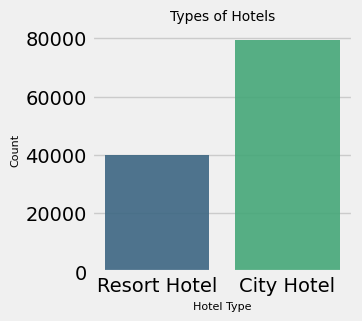

In [7]:
## Hotel Type Details
plt.figure(figsize=(3,3))
sns.countplot(x='hotel', data = hotel_data, palette = 'viridis', alpha=0.9)
plt.title('Types of Hotels', fontsize = 10)
plt.xlabel('Hotel Type', fontsize = 8)
plt.ylabel('Count', fontsize = 8)

0    75166
1    44224
Name: is_canceled, dtype: int64

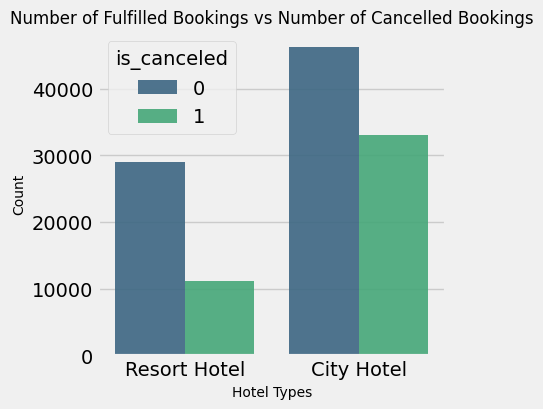

In [8]:
#'is_canceled' graph details
plt.figure(figsize=(4,4))
sns.countplot(data=hotel_data, x = 'hotel', hue='is_canceled', palette=double_palette, alpha=0.9)
plt.title('Number of Fulfilled Bookings vs Number of Cancelled Bookings', fontsize = 12)
plt.xlabel('Hotel Types', fontsize=10)
plt.ylabel('Count', fontsize=10)
count = hotel_data['is_canceled'].value_counts()
count

- From the above graph we can infer that the number of bookings for the city hotel is much higher when compared to the resort hotel and the cancellation rate is also high in city hotel.

(array([  0.,  50., 100., 150., 200.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200')])

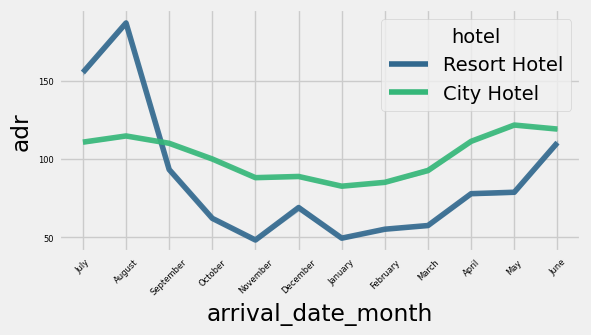

In [9]:
## Checking for the busiest month of the year
dfig = plt.figure(figsize=(6,3),dpi=100)
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
sns.lineplot(data=hotel_data, x= 'arrival_date_month', y = 'adr', hue='hotel', palette='viridis', alpha=0.9)
plt.xticks(rotation=45,fontsize=6)
plt.yticks(fontsize=6)

- This above line graph represents the Monthly Arrivals at Resort Hotel and City Hotel against the Average Daily Rate(adr).
- The Resort Hotel trend shows a lot of variation in arrivals during July, August till a sharp drop in values in November.

Text(0, 0.5, 'Count')

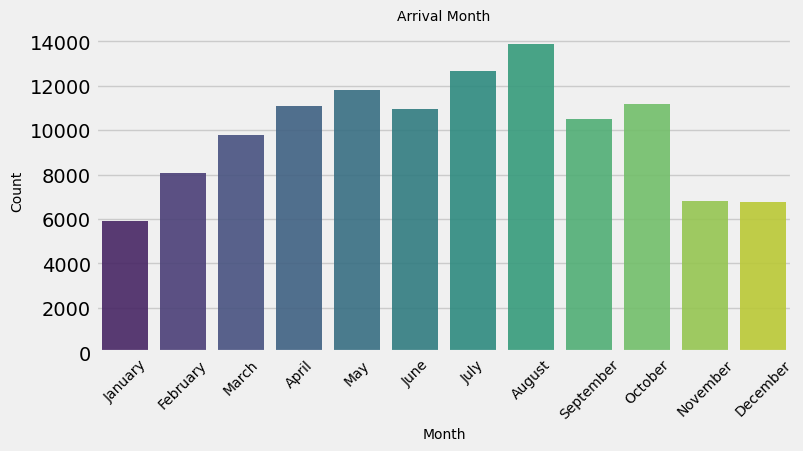

In [10]:
#'arrival_date_month' exploration 

plt.figure(figsize=(8,4))
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

sns.countplot(x='arrival_date_month', data=hotel_data, palette= 'viridis', order=months, alpha=0.9)
plt.title('Arrival Month', fontsize=10)
plt.xlabel('Month', fontsize=10)
plt.xticks(rotation=45,fontsize=10)
plt.ylabel('Count', fontsize=10)

- As we can see from the above plots: July & August are the busiest months of the year and hence their adr is high.
- Jan, Nov & Dec have the lowest activity and hence their adr is low. Jan is half as busy compared to Aug.
- In conclusion, the months in summer season are the busiest months for the hotels

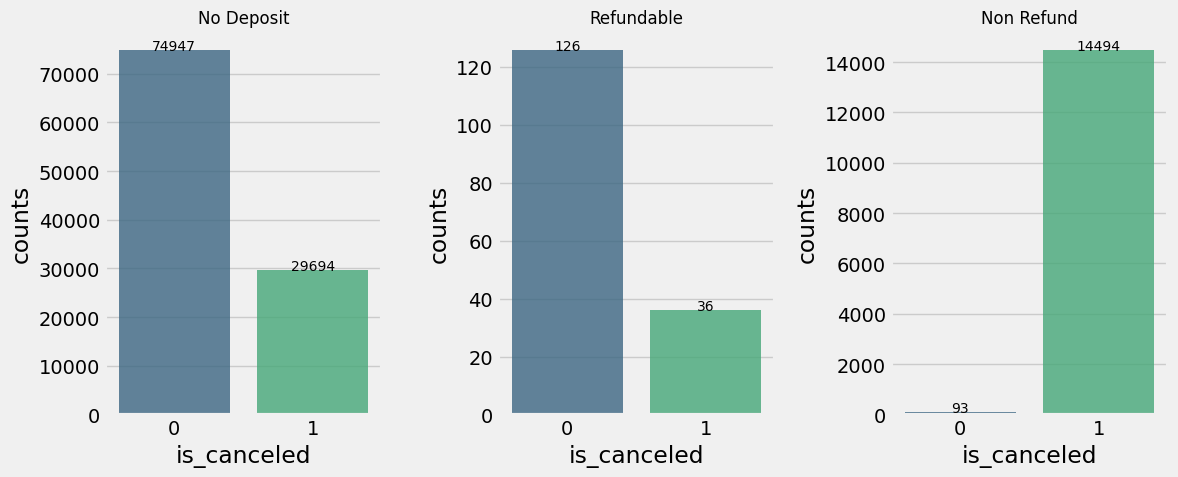

In [11]:
deposit_types = hotel_data['deposit_type'].unique()
nrows = 1
ncols = len(deposit_types)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 4, nrows * 5))

for i, deposit_type in enumerate(deposit_types):
    filtered_df = hotel_data[hotel_data['deposit_type'] == deposit_type]
    grouped = filtered_df.groupby('is_canceled').size().reset_index(name='counts')
    bar = sns.barplot(x='is_canceled', y='counts', data=grouped, ax=axs[i], palette=double_palette, alpha=0.8)
    for j in range(len(grouped)):
        count = grouped.loc[j, 'counts']
        bar.text(j, count , count, ha='center', va = 'baseline', fontsize=10)
    axs[i].set_title(deposit_type, fontsize=12)
plt.tight_layout()
plt.show()

- The above graph represents the relation between the deposit category and cancellations. 
- We can see that if there is no deposit required for booking then the number of bookings and the cancellations both are more. 
- Suprisingly, in the non-refund deposit category the number of cancelled bookings are more than the fulfilled bookings.

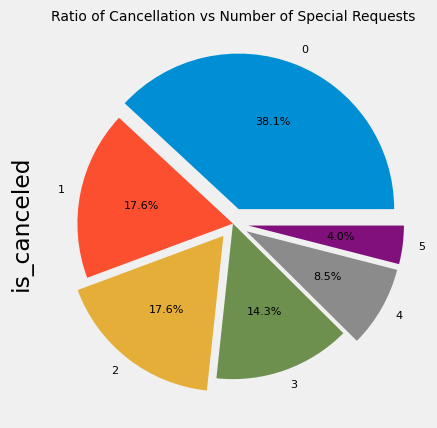

<Figure size 300x300 with 0 Axes>

In [12]:
group_adr_request = hotel_data.groupby(['total_of_special_requests'])['is_canceled'].mean().reset_index()
group_adr_request.plot(y='is_canceled', kind='pie', explode = (0.1, 0, 0.1, 0,0.1,0.1), autopct='%1.1f%%', startangle=0, shadow=False, labels=group_adr_request['total_of_special_requests'], legend=False, fontsize=8)
plt.title('Ratio of Cancellation vs Number of Special Requests', fontsize=10)
plt.figure(figsize=(3,3))
plt.show()

- The above graph represents the percentage of people cancelling the booking after making the number of special requests. 
- Here we can see that if guests make special requests then the chance of they cancelling the booking is low. This is  `directly proportional` to the number of special requests made for this data set.

Text(0.5, 1.0, 'Bookings and cancellations of Top 10 agents')

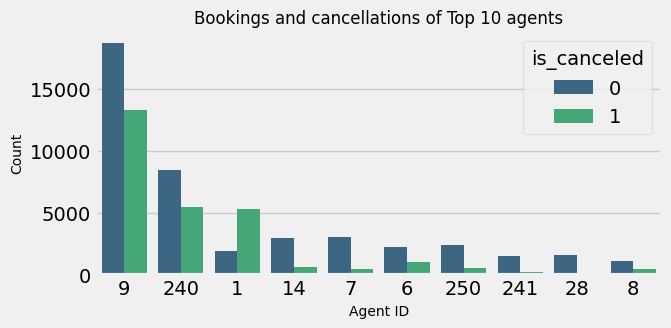

In [13]:
## Exploring the feature 'agent' w.r.t is_canceled
import math
plt.figure(figsize=(6.5,3))
agent_df=hotel_data.copy()
agent_df['agent'] = agent_df['agent'].fillna(0).astype(int)
agent_df = agent_df[agent_df['agent']!=0]
sns.countplot(x='agent', hue = 'is_canceled', data=agent_df, order=pd.value_counts(agent_df['agent']).iloc[:10].index, palette=double_palette)
plt.xlabel('Agent ID', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Bookings and cancellations of Top 10 agents', fontsize=12)

- The above graph represents the number of bookings and cancellations with respect to the top 10 agent IDs based on bookings count.
- We can see that the number of bookings from Agent ID 9 and 240 are much higher when compared to others. These agent ID also consist of majority number of bookings.
- From the above information, we can conclude that agent id 1 is either incompetent or a scam artist.

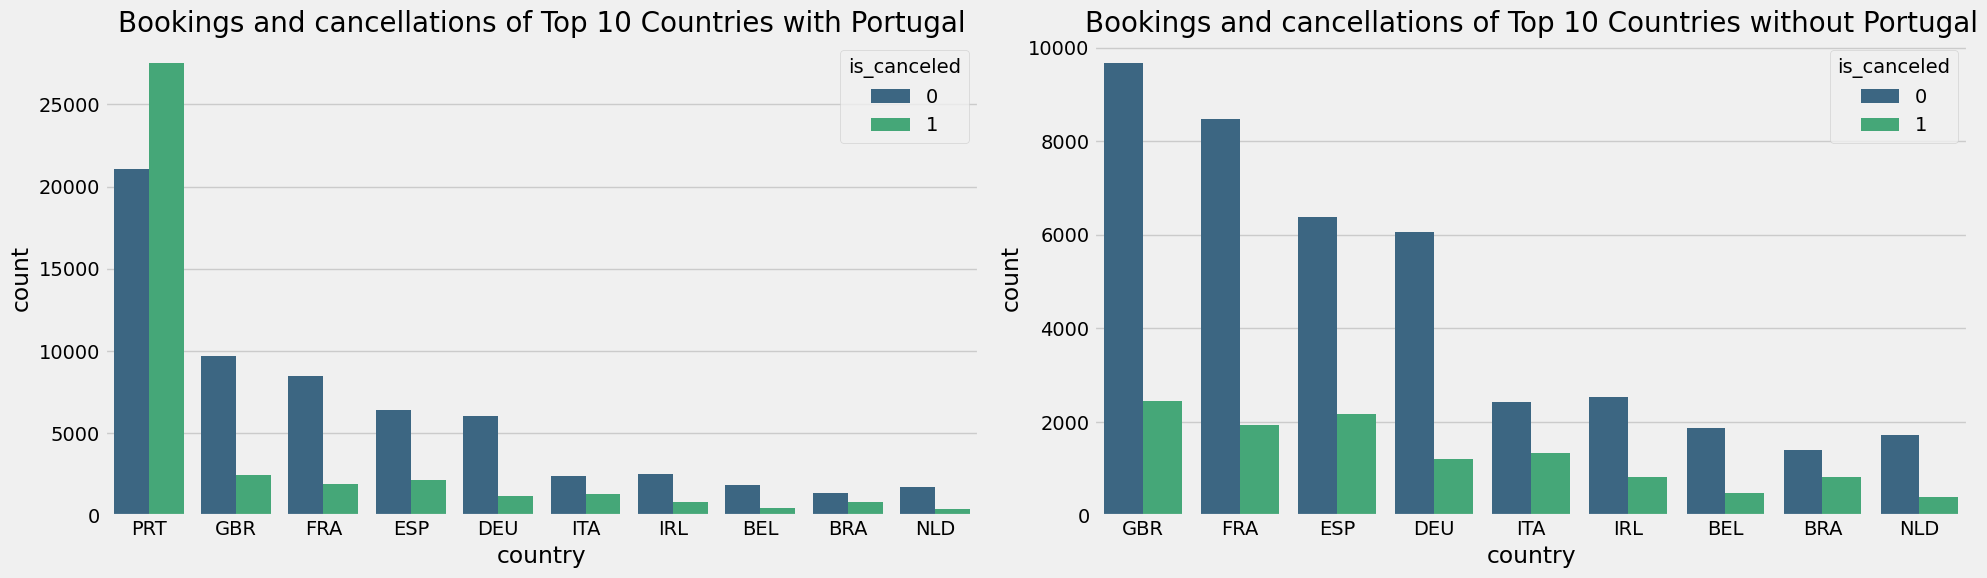

In [14]:
#Number of bookings and cancellations against the column 'country'
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,6))


sns.countplot(x='country', hue = 'is_canceled', data=hotel_data, order=pd.value_counts(hotel_data['country']).iloc[0:10].index, palette=double_palette,ax=ax1)
ax1.set_title('Bookings and cancellations of Top 10 Countries with Portugal', fontsize=20,)


sns.countplot(x='country', hue = 'is_canceled', data=hotel_data, order=pd.value_counts(hotel_data['country']).iloc[1:10].index, palette=double_palette,ax=ax2)
ax2.set_title('Bookings and cancellations of Top 10 Countries without Portugal', fontsize=20)

fig.tight_layout()
plt.show()

- The above graph represents the booking cancellations w.r.t the countries from where booking was done. 
- Since the Hotel is located in Portugual it is obvious that the maximum number of bookings are from Portugual. 
- The second graph depicts the number of cancellations from countries apart from Portugual. From the graph we can say that the countries neighbouring to Portugual have maximum number of bookings as compared to the other countries.

Text(0.5, 1.0, 'Number of bookings w.r.t to market segment')

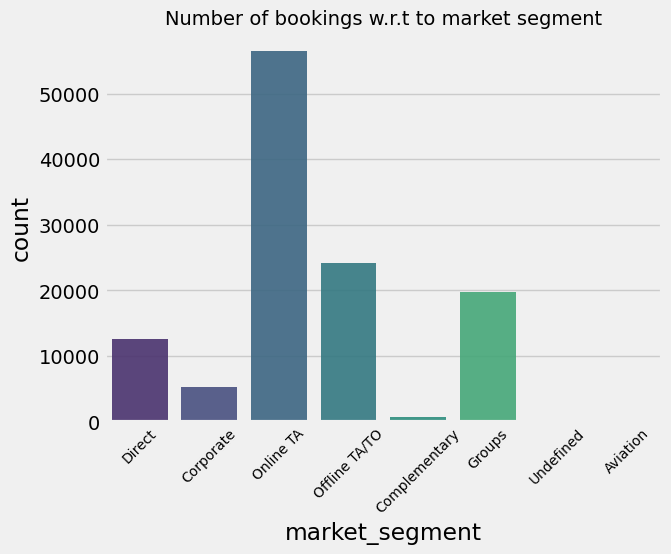

In [15]:
sns.countplot(data= hotel_data, x= 'market_segment', palette='viridis', alpha = 0.9)
plt.xticks(rotation=45,fontsize=10);
plt.title('Number of bookings w.r.t to market segment', fontsize=14)

- The above graph depicts the type of mode used for hotel booking VS the number of cancellations. 
- We can see that the most number of cancellations are from people who have done the hotel booking Online.

### 3. Data Cleaning and Preprocessing

- We have defined a function to perform all the data pre-processing and return the dataframe to avoid code redundancy since we are using a new dataset to make predictions using the combined model.
- The attributes with maximum Nan values are: 'agent' and 'company'. Attributes: 'children', 'country' also contain certain NaNs but they are of negligible count.
- Particularly, the NaNs dominate 'company'. Hence, 'company' will be removed as feature.
- Moreover, we need to perform Data Imputation for the attributes 'children', 'country' and 'agent' replace the NaNs values with the median values of that particular attribute.
- Since, 'country' is a categorical feature, we are filling the nans with mode.
- The values for babies, adults, and children can not be zero at the same time. So we will drop all the observations having zero at the same time.
- We are not dropping any duplicate values since we do not have any unique ID like a Booking ID or Booking Number. Hence, We cannot decide if a booking is a duplicate or not. 
- Furthermore, the accuracy of the model is increased without deleting the duplicates since we have many data points.
- Room assigned to the guests can play a vital role in the cancelation decision. 
- For eg., if a certain person reserves a room of Type A, but due to some reason they get assigned a room of Type C, they might opt to cancel their booking due to unavailability of their preferred room type.
- Hence, creating a new column 'Room_match' which has values '1' = reserved_room_type &  assigned_room_type are the same and 
  '0' = reserved_room_type &  assigned_room_type are different.

In [16]:
nan_counts = hotel_data.isnull().sum()
for column, nan_count in nan_counts.iteritems():
    if nan_count > 0:
        print(f"{column}: {nan_count}")

children: 4
country: 488
agent: 16340
company: 112593


In [17]:
def clean (df):

    df = df.copy()
    
    #Dropping 'company' & 'agent' -  # Replacing missing numerical values with median - # Replacing missing categorical values with mode 
    df.drop(['company', 'agent'], axis=1, inplace = True)
    df['children'] = df['children'].fillna(df['children'].median())    
    df['country']  = df['country'].fillna(df['country'].mode().index[0])

    ## Filtering and removing all rows where adults, children and babies are 0 at the same time
    filter = (df.children == 0) & (df.adults == 0) & (df.babies == 0)
    df[filter]
    df = df[~filter]

    # Create a new column 'Room_match' with values '1' if 'reserved_room_type' and 'assigned_room_type' match, '0' otherwise
    df['Room_match'] = (df['reserved_room_type'] == df['assigned_room_type']).astype(int)

    ## Dropping the unwanted columns with very less correlation
    df = df.drop(['reserved_room_type','assigned_room_type', 'distribution_channel','country','reservation_status','reservation_status_date' ], axis = 1)

    return df

In [18]:
## Copying the contents of hotel_data in clean_data so that we can use this dataframe separately in both the models as required. 
clean_data = hotel_data.copy()

In [19]:
hotel_data = clean(hotel_data)

In [20]:
hotel_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,Room_match
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,Direct,0,0,0,3,No Deposit,0,Transient,0.0,0,0,1
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,Direct,0,0,0,4,No Deposit,0,Transient,0.0,0,0,1
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,Direct,0,0,0,0,No Deposit,0,Transient,75.0,0,0,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,Corporate,0,0,0,0,No Deposit,0,Transient,75.0,0,0,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,Online TA,0,0,0,0,No Deposit,0,Transient,98.0,0,1,1


In [21]:
## Calculating the correlation of each feature with 'is_cancelled'.
correlation = hotel_data.corr()['is_canceled'].abs().sort_values(ascending = False)
correlation

is_canceled                       1.000000
lead_time                         0.292876
Room_match                        0.246768
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
adr                               0.046492
babies                            0.032569
stays_in_week_nights              0.025542
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_day_of_month         0.005948
children                          0.004851
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

### 4. Model 1 - Binary Classification

---

- Defining the features and label.
- Splitting the data set using HoldOut Validation first and then performing Stratified KFold for hyperparametric tuning.
- Using stratified Kfold instead of normal K fold because, the stratification ensures that each fold is representative of the entire dataset with respect to the class distribution.
- Stratified k-fold cv is particularly useful when dealing with imbalanced datasets, where the number of samples in each class is not equal. By ensuring that each fold has a balanced representation of each class, it helps to prevent bias in the evaluation of the model's performance.
- Tried feature selection using backward and also using lasso but the model underperformed both the times. So we have included all the features for training the model and it performed well. 
- Further we performed hyperparameter tuning to check if the accuracy and overall performace of the model can be improved. We'll use GridSearchCV for this purpose.

In [22]:
## Defining the features and label.

label    = 'is_canceled'
features_log = [column for column in hotel_data.columns if column != label]
X, y     = hotel_data[features_log], hotel_data[label]
print(features_log)

['hotel', 'lead_time', 'arrival_date_year', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'meal', 'market_segment', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'Room_match']


In [23]:
## Splitting the data set using HoldOut Validation first and then performing Stratified KFold for hyperparametric tuning
X_train, X_test1, y_train, y_test1 = train_test_split(X, y,stratify=y, test_size=0.3, random_state=420)
skf = StratifiedKFold(n_splits=5, random_state=420, shuffle=True)

#### 4.1 Logistic Regression Model - 'Predicting if the booking will be canceled or not'

In [24]:
### Extracting all the categorical columns from our dataset

cat_columns = hotel_data.select_dtypes(include=['object'])
cat_columns_names = cat_columns.columns
print(cat_columns_names)

Index(['hotel', 'arrival_date_month', 'meal', 'market_segment', 'deposit_type',
       'customer_type'],
      dtype='object')


#### 4.1.1 Fitting the model

In [25]:
### Defining a function that returns a pipeline performing OneHotEncoding, standardscaler and  logistic regression

def get_logistic_model(features):
    categorical_features = list(set(features) & set(['hotel', 'arrival_date_month', 'meal', 'market_segment','deposit_type', 'customer_type']))
    numerical_features = [col for col in features if col not in categorical_features]
    
    
    return make_pipeline(
        ColumnTransformer(transformers=[
             ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
             ('numerical', StandardScaler(), numerical_features)
        ]),
        LogisticRegression(penalty='l1', solver='liblinear', random_state=420))

In [26]:
#Fitting the model and printing the classification report
logit_reg = get_logistic_model(features_log)
logit_reg.fit(X_train, y_train)
y_pred_logit = logit_reg.predict(X_train)
print(classification_report(y_train, logit_reg.predict(X_train)))
print(classification_report(y_test1, logit_reg.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86     52508
           1       0.83      0.63      0.71     30939

    accuracy                           0.81     83447
   macro avg       0.82      0.78      0.79     83447
weighted avg       0.82      0.81      0.81     83447

              precision    recall  f1-score   support

           0       0.81      0.93      0.86     22503
           1       0.83      0.62      0.71     13260

    accuracy                           0.81     35763
   macro avg       0.82      0.77      0.79     35763
weighted avg       0.82      0.81      0.81     35763



In [27]:
#Printing Confusion Matrix
cm = confusion_matrix(y_train, logit_reg.predict(X_train))
print(cm)

[[48632  3876]
 [11597 19342]]


#### 4.1.2 Hyperparametric Tuning

In [28]:
# Define the parameter grid to search over
LRparam_grid = {
    'logisticregression__C': [ 0.01, 0.1],
    'logisticregression__tol': [0.0001, 0.001, 0.01]
}

model = get_logistic_model(features_log)

# Create the grid search object
grid_search = GridSearchCV(model, param_grid=LRparam_grid, cv=skf, verbose = 3, scoring='accuracy')

# Fit the grid search object on the training set
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", grid_search.best_params_)
print("Best Accuracy: ", grid_search.best_score_)        

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logisticregression__C=0.01, logisticregression__tol=0.0001;, score=0.816 total time=   0.7s
[CV 2/5] END logisticregression__C=0.01, logisticregression__tol=0.0001;, score=0.813 total time=   0.7s
[CV 3/5] END logisticregression__C=0.01, logisticregression__tol=0.0001;, score=0.815 total time=   0.8s
[CV 4/5] END logisticregression__C=0.01, logisticregression__tol=0.0001;, score=0.812 total time=   0.8s
[CV 5/5] END logisticregression__C=0.01, logisticregression__tol=0.0001;, score=0.811 total time=   0.7s
[CV 1/5] END logisticregression__C=0.01, logisticregression__tol=0.001;, score=0.816 total time=   0.6s
[CV 2/5] END logisticregression__C=0.01, logisticregression__tol=0.001;, score=0.813 total time=   0.7s
[CV 3/5] END logisticregression__C=0.01, logisticregression__tol=0.001;, score=0.815 total time=   0.7s
[CV 4/5] END logisticregression__C=0.01, logisticregression__tol=0.001;, score=0.811 total time=   0.8s

- For Gridsearch CV we are using the parameters 'logisticregression__C' & 'logisticregression__tol' to extract the best hyperparameters for our model.
- We are not using the parameter 'max_iter' since we are using penalty 'l1'.
- We get the best hyperparameters as 'logisticregression__C': 0.1, 'logisticregression__tol': 0.01'


In [29]:
### Defining the categorical & Numerical features for hyperparameter tuning
categorical_features = list(set(features_log) & set(['hotel', 'arrival_date_month', 'meal', 'market_segment','deposit_type', 'customer_type']))
numerical_features   = [col for col in features_log if col not in categorical_features]

In [30]:
#Logistic Regression after Hyperparametric Tuning - using the parameters we obtained above
logit_reg_hyp = make_pipeline(ColumnTransformer(transformers=[('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features), ('numerical', StandardScaler(), numerical_features)]),
                              LogisticRegression(C=0.01, penalty='l1', tol= 0.01,  solver='liblinear', random_state=420))
logit_reg_hyp.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customer_type',
                                                   'deposit_type', 'meal',
                                                   'hotel', 'market_segment',
                                                   'arrival_date_month']),
                                                 ('numerical', StandardScaler(),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nigh...
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'adr',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'Room_match'])])),
                ('logisticregression',
                 LogisticRegression(C=0.01, penalty='l1', random_state=420,
                                    solver='liblinear', tol=0.01))])

In [31]:
### Confusion matrix for training data
cm = confusion_matrix(y_train, logit_reg_hyp.predict(X_train))
cm

array([[48952,  3556],
       [11984, 18955]], dtype=int64)

In [32]:
print(classification_report(y_train, logit_reg_hyp.predict(X_train)))
print(classification_report(y_test1, logit_reg_hyp.predict(X_test1)))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86     52508
           1       0.84      0.61      0.71     30939

    accuracy                           0.81     83447
   macro avg       0.82      0.77      0.79     83447
weighted avg       0.82      0.81      0.81     83447

              precision    recall  f1-score   support

           0       0.80      0.93      0.86     22503
           1       0.84      0.61      0.71     13260

    accuracy                           0.81     35763
   macro avg       0.82      0.77      0.78     35763
weighted avg       0.82      0.81      0.80     35763



#### Comments:

- As we can see from the above classification report, our accuracy on training and test set remains the same i.e. 81% & F1 score also stays the same i.e 0.86 for class '0' & 0.71 for class '1'


### 5. Model 2 :- Regression
---
#### 5.1 Data Preparation
1. Filtering out the cancelled data from the original dataset. 
2. We have created a new column 'arrival_date' using arrival date information from other columns.
3. Since we don't have the data to predict how many days in advance the guest cancels, we created a new column ' No. of Days Cancellation'  using 'arrival date' and 'reservation status date'.
4. Dropping the repeated columns.

In [33]:
clean_data.shape

(119390, 32)

In [34]:
clean_data.drop(clean_data[clean_data['is_canceled'] == 0].index, inplace = True)
clean_data.shape

(44224, 32)

In [35]:
# Creating 'arrival_date' column

def map_months(x):

  if x == 'January':
    x = 1
  elif x == 'February':
    x = 2
  elif x == 'March':
    x = 3
  elif x == 'April':
    x = 4
  elif x == 'May':
    x = 5
  elif x == 'June':
    x = 6
  elif x == 'July':
    x = 7
  elif x == 'August':
    x = 8
  elif x == 'September':
    x = 9
  elif x == 'October':
    x = 10
  elif x == 'November':
    x = 11
    
  elif x == 'December':
    x = 12
  return x

clean_data['arrival_date_month_number'] = clean_data['arrival_date_month'].apply(lambda x : map_months(x))
clean_data['arrival_date'] = clean_data['arrival_date_month_number'].astype('str') + '/'+ clean_data['arrival_date_day_of_month'].astype('str') + '/' +  clean_data['arrival_date_year'].astype('str')
clean_data['arrival_date'] = pd.to_datetime(clean_data['arrival_date'])
clean_data['reservation_status_date'] = pd.to_datetime(clean_data['reservation_status_date'])
clean_data['no_of_days_cancellation'] = clean_data['arrival_date'] - clean_data['reservation_status_date']
clean_data['no_of_days_cancellation']

8        56 days
9        70 days
10        8 days
27       51 days
32       33 days
           ...  
110280    0 days
111355    0 days
111924    0 days
111925    0 days
117295    0 days
Name: no_of_days_cancellation, Length: 44224, dtype: timedelta64[ns]

In [36]:
#Removing the string 'days' from the output and storing the integer value in the new column 'no_of_days_cancellation'
clean_data['no_of_days_cancellation'] = clean_data['no_of_days_cancellation'].dt.days
clean_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date_month_number,arrival_date,no_of_days_cancellation
8,Resort Hotel,1,85,2015,July,27,1,0,3,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,82.0,0,1,Canceled,2015-05-06,7,2015-07-01,56
9,Resort Hotel,1,75,2015,July,27,1,0,3,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,D,D,0,No Deposit,15.0,NaN,0,Transient,105.5,0,0,Canceled,2015-04-22,7,2015-07-01,70
10,Resort Hotel,1,23,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240.0,NaN,0,Transient,123.0,0,0,Canceled,2015-06-23,7,2015-07-01,8
27,Resort Hotel,1,60,2015,July,27,1,2,5,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,240.0,NaN,0,Transient,107.0,0,2,Canceled,2015-05-11,7,2015-07-01,51
32,Resort Hotel,1,96,2015,July,27,1,2,8,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,E,E,0,No Deposit,NaN,NaN,0,Transient,108.3,0,2,Canceled,2015-05-29,7,2015-07-01,33


In [37]:
clean_data = clean(clean_data)

In [38]:
clean_data = clean_data.drop(['is_canceled', 'arrival_date','arrival_date_day_of_month', 'arrival_date_month_number'], axis=1)
clean_data.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,no_of_days_cancellation,Room_match
8,Resort Hotel,85,2015,July,27,0,3,2,0.0,0,BB,Online TA,0,0,0,0,No Deposit,0,Transient,82.0,0,1,56,1
9,Resort Hotel,75,2015,July,27,0,3,2,0.0,0,HB,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,105.5,0,0,70,1
10,Resort Hotel,23,2015,July,27,0,4,2,0.0,0,BB,Online TA,0,0,0,0,No Deposit,0,Transient,123.0,0,0,8,1
27,Resort Hotel,60,2015,July,27,2,5,2,0.0,0,BB,Online TA,0,0,0,0,No Deposit,0,Transient,107.0,0,2,51,1
32,Resort Hotel,96,2015,July,27,2,8,2,0.0,0,BB,Direct,0,0,0,0,No Deposit,0,Transient,108.3,0,2,33,1


In [39]:
correlation = clean_data.corr(method='pearson')['no_of_days_cancellation'].abs().sort_values(ascending = False)
correlation

no_of_days_cancellation           1.000000
lead_time                         0.724987
total_of_special_requests         0.143360
Room_match                        0.107225
adr                               0.103663
arrival_date_week_number          0.088824
arrival_date_year                 0.079111
stays_in_weekend_nights           0.065040
booking_changes                   0.064163
adults                            0.061750
previous_cancellations            0.060480
stays_in_week_nights              0.047307
children                          0.042055
is_repeated_guest                 0.040023
previous_bookings_not_canceled    0.021201
babies                            0.019473
days_in_waiting_list              0.010505
required_car_parking_spaces            NaN
Name: no_of_days_cancellation, dtype: float64

Here we can see the column 'lead time' has a very good correlation w.r.t no_of_days_cancellation

In [40]:
# Find categorical columns that should be encoded
cat_columns = clean_data.select_dtypes(include=['object'])
cat_columns_names = cat_columns.columns
print(cat_columns_names)

Index(['hotel', 'arrival_date_month', 'meal', 'market_segment', 'deposit_type',
       'customer_type'],
      dtype='object')


### 5.2 Model Selection and fitting the model 

- Defining the features and label.
- Used 5-Fold cross-validation to assess the out-of-sample accuracy of two regression models (linear and quadratic regression).
- Splitting the data set using HoldOut Validation first and then performing KFold for hyperparametric tuning.
- Performed feature selection using backward feature selection method and fitted the model using the best features.
- Further we performed hyperparameter tuning to check if the accuracy and overall performace of the model can be improved.

In [41]:
label = 'no_of_days_cancellation'
features = [column for column in clean_data.columns if column != label]
X1, y1 = clean_data[features], clean_data[label]
features

['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'market_segment',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'Room_match']

In [42]:
#Multiple Linear Regression
def get_model(features):
    categorical_features = list(set(features) & set(['hotel', 'arrival_date_month', 'meal', 'market_segment','deposit_type', 'customer_type']))
    numerical_features = [col for col in features if col not in categorical_features]
    
    
    return make_pipeline(
        ColumnTransformer(transformers=[
             ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
             ('numerical', StandardScaler(), numerical_features)
        ]),
        LinearRegression())

In [43]:
# Polynomial regression with degree 2
def get_model1(features):
    categorical_features = list(set(features) & set(['hotel', 'arrival_date_month', 'meal', 'market_segment','deposit_type', 'customer_type']))
    numerical_features = [col for col in features if col not in categorical_features]
    
    
    return make_pipeline(    
    ColumnTransformer(transformers=[
             ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
             ('numerical', StandardScaler(), numerical_features)
        ]),
    PolynomialFeatures(degree=2),    
    LinearRegression())

In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

In [45]:
sol_linear = cross_val_score(
            estimator=get_model(features),
            X=X1, y=y1, cv=kf,
            scoring='neg_mean_squared_error')

In [46]:
-1 * np.mean(sol_linear)

3218.928635103737

In [47]:
sol_quadratic = cross_val_score(
                estimator=get_model1(features),
                X=X1, y=y1, cv=kf,
                scoring='neg_mean_squared_error')

In [48]:
-1 * np.mean(sol_quadratic)

3.248030374247802e+20

From the above Negative MSEs we can see that Linear regression has a much lower error compared to polynomial. So we are progressing with Multiple Linear Regression

#### 5.2.1 Backward Feature Selection

In [68]:
from sklearn.metrics import mean_squared_error
class Solution:
    features = list()
    mse = float('Inf')
    
    def __init__(self, y1, features=None, mse=None):
        if features and mse:
            self.features = features
            self.mse = mse
        else:
            pred = [y1.mean()] * len(y1)
            self.features = list()
            self.mse = mean_squared_error(y1, pred)
    
    def update(self, features, mse):
        if mse < self.mse:
            self.features = features
            self.mse = mse
            return True
        return False

current_features = list(features)
best = Solution(
    y1=y1,
    features=current_features,
    mse=-np.average(
        cross_val_score(
            estimator=get_model(current_features),
            X=X1, y=y1, cv=kf,
            scoring='neg_mean_squared_error')))

while len(current_features) > 0:
    removed_feature = None
    
    for feature in current_features:
        new_features = [f for f in current_features if f != feature]
        mses = cross_val_score(
            estimator=get_model(new_features),
            X=X1[new_features], y=y1, cv=kf,
            scoring='neg_mean_squared_error')
        mse = -np.average(mses)
        
        if best.update(new_features, mse):
            removed_feature = feature
            
    if removed_feature:
        current_features.remove(removed_feature)
    else:
        break

In [69]:
print('Selected features: ', end='')
print(', '.join(best.features))
reg_features= best.features
reg_features 

Selected features: hotel, lead_time, arrival_date_year, arrival_date_month, arrival_date_week_number, stays_in_weekend_nights, stays_in_week_nights, meal, market_segment, is_repeated_guest, previous_cancellations, previous_bookings_not_canceled, booking_changes, deposit_type, days_in_waiting_list, customer_type, required_car_parking_spaces, total_of_special_requests, Room_match


['hotel',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'meal',
 'market_segment',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'deposit_type',
 'days_in_waiting_list',
 'customer_type',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'Room_match']

#### 5.2.2 Fitting the model using the features

In [70]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X1[best.features], y1, test_size=0.2, random_state=0)

model = get_model(best.features)

# Fit the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)
print('R2 Score:', r2_score(y_test, y_pred))
print('Accuracy: {:.2f}'.format(model.score(X_test, y_test)))

Mean squared error:  3166.6905334110174
R2 Score: 0.6245153512437247
Accuracy: 0.62


#### 5.2.3 Hyperparametric Tuning

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the parameter grid to search over
Lin_R = {
    'linearregression__fit_intercept': [True, False],
    'linearregression__copy_X': [True, False],
    'linearregression__positive': [True, False]
}

model = get_model(best.features)

# Create the grid search object
grid_search = GridSearchCV(model, param_grid=Lin_R, cv=kf, scoring='neg_mean_squared_error')

# Fit the grid search object on the training set
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", grid_search.best_params_)
print("Best mean squared error: ", -grid_search.best_score_)

Best hyperparameters:  {'linearregression__copy_X': True, 'linearregression__fit_intercept': False, 'linearregression__positive': False}
Best mean squared error:  3233.2728680549812


In [72]:
categorical_features = list(set(best.features) & set(['hotel', 'arrival_date_month', 'meal', 'market_segment','deposit_type', 'customer_type']))
numerical_features = [col for col in best.features if col not in categorical_features]

In [73]:
lr = make_pipeline(
        ColumnTransformer(transformers=[
             ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_features),
             ('numerical', StandardScaler(), numerical_features)
        ]),
        LinearRegression(fit_intercept=False, copy_X=True, positive= False ))

In [74]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluate the performance of the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
print('Mean squared error: ', mse)

Mean squared error:  3166.1659050700855


In [75]:
y_pred

array([ 91.43592656,  31.94813359,  89.53944219, ...,  19.86113979,
       108.46131719,  77.47596562])

In [76]:
r2_test = r2_score(y_test, y_pred)
print("R-squared value for test set:", r2_test)
print('Accuracy: {:.2f}'.format(lr.score(X_test, y_test)))

R-squared value for test set: 0.6245775581080344
Accuracy: 0.62


From the above values we can say that, after hyperparametric tuning our MSE has improved slightly and r2 value and accuracy are still the same.

##### Fitting both the models with the entire data set

In [77]:
logit_reg_hyp.fit(X,y)
lr.fit(X1,y1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customer_type',
                                                   'deposit_type', 'meal',
                                                   'hotel', 'market_segment',
                                                   'arrival_date_month']),
                                                 ('numerical', StandardScaler(),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_week_number',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'is_repeated_guest',
                                                   'previous_cancellations',
                                                   'previous_bookings_not_canceled',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'Room_match'])])),
                ('linearregression', LinearRegression(fit_intercept=False))])

### 6. Prediction Tool - combining both the models
---

* Importing a csv file with raw dataset as base dataset.
* Cleaning the dataset using the clean function which we have defined earlier.
* Predicting the results for the new dataset

In [78]:
predict_data = pd.read_csv('Test_Data.csv')
predict_data = clean(predict_data)

In [79]:
predict_data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,Room_match
0,City Hotel,1,14,2016,April,17,18,1,3,2,2,0,BB,Online TA,0,0,0,0,No Deposit,0,Transient,191.50,0,0,1
1,City Hotel,1,104,2016,April,17,18,1,3,1,0,0,BB,Online TA,0,0,0,0,No Deposit,0,Transient,72.25,0,1,1
2,City Hotel,0,105,2016,April,17,18,1,3,2,0,0,BB,Online TA,0,0,0,0,No Deposit,0,Transient,82.45,0,0,1
3,City Hotel,0,130,2016,April,17,18,1,3,2,0,0,BB,Online TA,0,0,0,0,No Deposit,0,Transient,84.15,0,0,1
4,City Hotel,0,127,2016,April,17,18,1,3,2,0,0,SC,Online TA,0,0,0,0,No Deposit,0,Transient,53.25,0,0,1


In [80]:
def prediction_tool(X):
      
        status_features = X[features_log]
        cancellation_pred = logit_reg_hyp.predict(status_features)
    
        days_features = X[reg_features]
        time_pred = lr.predict(days_features)
        
        
        b=0
        test_str = 'Not canceled'
        pred_dict = {"Position":[],"Is_Cancelled":[],"Advance_Days":[]};

        for a in cancellation_pred:
            
            if a == 0:
                pred_dict["Position"].append(b+1)
                pred_dict["Is_Cancelled"].append(cancellation_pred[b])
                pred_dict["Advance_Days"]+= [test_str]
                #print(cancellation_pred[b], test_str)
            
            else:
                pred_dict["Position"].append(b+1)
                pred_dict["Is_Cancelled"].append(cancellation_pred[b])
                pred_dict["Advance_Days"].append(int(time_pred[b]))
                #print(cancellation_pred[b], time_pred[b].round(0))
            b = b+1
        return pred_dict  
           

In [81]:
results = prediction_tool(predict_data)

for i in range(len(results["Position"])):
    position = results["Position"][i]
    is_cancelled = results["Is_Cancelled"][i]
    advance_days = results["Advance_Days"][i]
    if advance_days == 'Not canceled':
        print(f"Booking: {position} -- The Booking will not be canceled")
    else:
        print(f"Booking: {position} -- Will be canceled in {advance_days} days")    

Booking: 1 -- Will be canceled in 21 days
Booking: 2 -- The Booking will not be canceled
Booking: 3 -- Will be canceled in 69 days
Booking: 4 -- Will be canceled in 83 days
Booking: 5 -- Will be canceled in 78 days
Booking: 6 -- The Booking will not be canceled
Booking: 7 -- The Booking will not be canceled
Booking: 8 -- Will be canceled in 75 days
Booking: 9 -- Will be canceled in 31 days
Booking: 10 -- The Booking will not be canceled
Booking: 11 -- The Booking will not be canceled
Booking: 12 -- Will be canceled in 155 days
Booking: 13 -- The Booking will not be canceled
Booking: 14 -- Will be canceled in 155 days
Booking: 15 -- Will be canceled in 155 days
Booking: 16 -- Will be canceled in 155 days
Booking: 17 -- Will be canceled in 155 days
Booking: 18 -- The Booking will not be canceled
Booking: 19 -- The Booking will not be canceled
Booking: 20 -- Will be canceled in 96 days
Booking: 21 -- Will be canceled in 96 days
Booking: 22 -- Will be canceled in 96 days
Booking: 23 -- Wil

### 7. Summary and Conclusion
---

- After performing EDA on our dataset, we performed several data cleaning processes and data preparation before feeding the data to the models.

- Model 1: We have split the data using Hold-Out validation first and then with 'Stratified KFold CV'. Further created a pipeline for our classifiers and then applied Hyperparameter tuning to get the best parameters for our model. After training the model on our train data and then on test data, we generated our confusion matrix and classification report. 

- We compared two classifiers : 1) Logistic Regression & 2) Random Forest Classifier, to predict the cancellations. Due to computational complexity and cost restrictions in Random Forest, we found 'Logistic Regression' to be a better choice.

- Given a new dataset, our model(logit_reg_hyp) is now ready to predict whether or not a hotel booking will be canceled with 81% accuracy.

##### The screen Shot of Random Forest Hyperparametric Tuning is given below

![alternative text](RD_Forest.jpg)

- Model 2: Predicting the number of days in advance the hotel booking might get canceled.

-  We have split the data using Hold-Out validation followed by 'KFold CV'. Further created a pipeline for our classifiers and then applied Hyperparameter tuning to get the best parameters. After training and testing the model, we generated our mean square error for model comparison.

- used 5-Fold cross-validation to assess the out-of-sample accuracy of two regression models (linear and quadratic regression). The mean square error for Linear Regression(3218.928635103737) model was significantly lesser compared to the polynomial model (3.248030374247802e+20). Hence, we decided to go ahead with the Linear Regression Model.

- Here, we have first implemented backward feature selection and selected the best features. 

- Our model(lr) is now ready to predict the number of days in advance the hotel booking might get canceled with 62% accuracy.